In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




In [2]:
def extract_time (data):
  """Returns Maximum sequence length and each sequence length.
  
  Args:
    - data: original data
    
  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
  time = list()
  max_seq_len = 0
  for i in range(len(data)):
    max_seq_len = max(max_seq_len, len(data[i][:,0]))
    time.append(len(data[i][:,0]))
    
  return time, max_seq_len

def random_generator (batch_size, z_dim, T_mb, max_seq_len):
  """Random vector generation.
  
  Args:
    - batch_size: size of the random vector
    - z_dim: dimension of random vector
    - T_mb: time information for the random vector
    - max_seq_len: maximum sequence length
    
  Returns:
    - Z_mb: generated random vector
  """
  Z_mb = list()
  for i in range(batch_size):
    temp = np.zeros([max_seq_len, z_dim])
    temp_Z = np.random.uniform(0., 10, [T_mb[i], z_dim])
    temp[:T_mb[i],:] = temp_Z
    Z_mb.append(temp_Z)
  return Z_mb


In [3]:
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

Define Class for Module Construction

In [4]:
class Time_GAN_module(nn.Module):
    """
    Class from which a module of the Time GAN Architecture can be constructed, 
    consisting of a n_layer stacked RNN layers and a fully connected layer
    
    input_size = dim of data (depending if module operates on latent or non-latent space)
    """
    def __init__(self, input_size, output_size, hidden_dim, n_layers, activation=torch.sigmoid):
        super(Time_GAN_module, self).__init__()

        # Parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.sigma = activation

        #Defining the layers
        # RNN Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
    
            batch_size = x.size(0)

            # Initializing hidden state for first input using method defined below
            hidden = self.init_hidden(batch_size)

            # Passing in the input and hidden state into the model and obtaining outputs
            out, hidden = self.rnn(x, hidden)
        
            # Reshaping the outputs such that it can be fit into the fully connected layer
            out = out.contiguous().view(-1, self.hidden_dim)
            out = self.fc(out)
            
            if self.sigma == nn.Identity:
                idendity = nn.Identity()
                return idendity(out)
                
            out = self.sigma(out)
            
            # HIDDEN STATES WERDEN IN DER PAPER IMPLEMENTIERUNG AUCH COMPUTED, ALLERDINGS NICHT BENUTZT?
            
            return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

Parameters

In [5]:
input_size = 5 # sequence length = number of features
output_size = 20
hidden_dim = 40
n_layers = 1
gamma = 1

no, seq_len, dim = 12800, 24, 1

batch_size = 128
epoch = 100

Data Generation

In [6]:
data = sine_data_generation(no, seq_len, dim)
data = MinMaxScaler(data)
data = torch.Tensor(data)
data.shape

torch.Size([12800, 24, 1])

Create Modules

Data Loader

In [7]:
from torch.utils.data import DataLoader

loader = DataLoader(data, batch_size, shuffle=False)

random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])

In [12]:
def TimeGAN(data, parameters):
  hidden_dim = parameters["hidden_dim"]
  num_layers = parameters["num_layers"]
  iterations = parameters["iterations"]
  batch_size = parameters["batch_size"]
  module = parameters["module"]
  epoch = parameters["epoch"]
  no, seq_len, dim = np.asarray(data).shape
  z_dim = dim
  gamma = 1

  checkpoints = {}

  Embedder = Time_GAN_module(input_size=z_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=num_layers)
  Recovery = Time_GAN_module(input_size=hidden_dim, output_size=dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Generator = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Supervisor = Time_GAN_module(input_size=hidden_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Discriminator = Time_GAN_module(input_size=hidden_dim, output_size=1, hidden_dim=hidden_dim, n_layers=n_layers, activation=nn.Identity)

  embedder_optimizer = optim.Adam(Embedder.parameters(), lr=0.0035)
  recovery_optimizer = optim.Adam(Recovery.parameters(), lr=0.01)
  supervisor_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
  discriminator_optimizer = optim.Adam(Discriminator.parameters(), lr=0.01)
  generator_optimizer = optim.Adam(Generator.parameters(), lr=0.01)
  

  binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
  MSE_loss = nn.MSELoss()
  
  # Embedding Network Training
  print('Start Embedding Network Training')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):
                
        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        X_tilde, _ = Recovery(H)
        X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

        E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  

        Embedder.zero_grad()
        Recovery.zero_grad()

        E_loss0.backward(retain_graph=True)

        embedder_optimizer.step()
        recovery_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', e_loss: ' + str(np.sqrt(E_loss0.detach().numpy())))

  print('Finish Embedding Network Training')

  # Training only with supervised loss
  print('Start Training with Supervised Loss Only')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):

        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        H_hat_supervise, _ = Supervisor(H)
        H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

        G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])


        Embedder.zero_grad()
        Supervisor.zero_grad()

        G_loss_S.backward(retain_graph=True)

        embedder_optimizer.step()
        supervisor_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', s_loss: ' + str(np.sqrt(G_loss_S.detach().numpy())))

  print('Finish Training with Supervised Loss Only')
  # Joint Training
  

  print('Start Joint Training')
  for itt in range(epoch):
    for kk in range(2):
      X = next(iter(loader))
      random_data #= random_generator(batch_size=batch_size, z_dim=dim, 
                                       #T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
        
      # Generator Training 
      ## Train Generator
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()

      # line 267 of original implementation: 
      # G_loss_U, G_loss_S, G_loss_V
      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      # logits first, then targets
      # D_loss_real(Y_real, torch.ones_like(Y_real))
      G_loss_U = binary_cross_entropy_loss(Y_fake, torch.ones_like(Y_fake))
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#


      generator_optimizer.step()
      supervisor_optimizer.step()
      discriminator_optimizer.step()
      # Train Embedder 
      ## line 270: we only optimize E_loss_T0
      ## E_loss_T0 = just mse of x and x_tilde
      # but it calls E_solver which optimizes E_loss, which is a sum of 
      # E_loss0 and 0.1* G_loss_S
      MSE_loss = nn.MSELoss()
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
        
      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      G_loss_S.backward(retain_graph=True)
      E_loss_T0.backward()
        
      Embedder.zero_grad()
      Recovery.zero_grad()
      Supervisor.zero_grad()
        
      embedder_optimizer.step()
      recovery_optimizer.step()
      supervisor_optimizer.step()
    # train Discriminator
    for batch_index, X in enumerate(loader):
      random_data #= random_generator(batch_size=batch_size, z_dim=dim, 
                                       #T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
      
      z = torch.tensor(random_data)
      z = z.float()

      H, _ = Embedder(X)
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      Y_real = Discriminator(H)
      Y_real = torch.reshape(Y_real, (batch_size, seq_len, 1))
      
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))

      Y_fake_e = Discriminator(e_hat)
      Y_fake_e = torch.reshape(Y_fake_e, (batch_size, seq_len, 1))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()
      Embedder.zero_grad()

      # logits first, then targets
      # D_loss_real(Y_real, torch.ones_like(Y_real))
      D_loss_real = nn.BCEWithLogitsLoss()
      DLR = D_loss_real(Y_real, torch.ones_like(Y_real))

      D_loss_fake = nn.BCEWithLogitsLoss()
      DLF = D_loss_fake(Y_fake, torch.zeros_like(Y_fake))

      D_loss_fake_e = nn.BCEWithLogitsLoss()
      DLF_e = D_loss_fake_e(Y_fake_e, torch.zeros_like(Y_fake_e))

      D_loss = DLR + DLF + gamma * DLF_e

      # check discriminator loss before updating
      check_d_loss = D_loss
      if (check_d_loss > 0.15):
        D_loss.backward(retain_graph=True)
        discriminator_optimizer.step()        
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim)) 
        
      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      # logits first then targets
      G_loss_U = binary_cross_entropy_loss(Y_fake, torch.ones_like(Y_fake))
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
    
      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#
      E_loss.backward()

      generator_optimizer.step()
      supervisor_optimizer.step()
      embedder_optimizer.step()
      recovery_optimizer.step()
            
      print('step: '+ str(itt) + '/' + str(epoch) + 
            ', D_loss: ' + str(D_loss.detach().numpy()) +
            ', G_loss_U: ' + str(G_loss_U.detach().numpy()) + 
            ', G_loss_S: ' + str(G_loss_S.detach().numpy()) + 
            ', E_loss_t0: ' + str(np.sqrt(E_loss0.detach().numpy())))
         

      
      random_test = random_generator(1, dim, extract_time(data)[0], extract_time(data)[1])        
      test_sample = Generator(torch.tensor(random_generator(1, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]      
      test_sample = torch.reshape(test_sample, (1, seq_len, hidden_dim))
      test_recovery = Recovery(test_sample)
      test_recovery = torch.reshape(test_recovery[0], (1, seq_len, dim))
      fig, ax = plt.subplots()
      ax1 = plt.plot(test_recovery[0].detach().numpy())
      plt.show()
      
      if itt % 2:
        checkpoints[itt] = [Generator.state_dict(), Discriminator.state_dict(), Embedder.state_dict(), Recovery.state_dict,
                    Supervisor.state_dict()]
             
  print('Finish Joint Training')
        
  random_test = random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])
  test_sample = Generator(torch.tensor(random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]
  test_sample = torch.reshape(test, (12800, seq_len, hidden_dim))
  test_recovery = Recovery(test_sample)
  test_recovery = torch.reshape(test_recovery[0], (12800, seq_len, dim))
  visualization(data, test_recovery.detach().numpy(), 'tsne')
  visualization(data, test_recovery.detach().numpy(), 'pca')
  
    
    
  return Generator, Embedder, Supervisor, Recovery, Discriminator, test, test_recovery, checkpoints
  
    

In [9]:
parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 40
parameters['num_layers'] = 1
parameters['iterations'] = 10000
parameters['batch_size'] = 128
parameters['epoch'] = 2

Start Embedding Network Training
step: 1/2, e_loss: 0.47473982
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 1/2, s_loss: 0.1014306
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/2, D_loss: 3.4109573, G_loss_U: 0.2933319, G_loss_S: 0.0066051786, E_loss_t0: 2.2793045


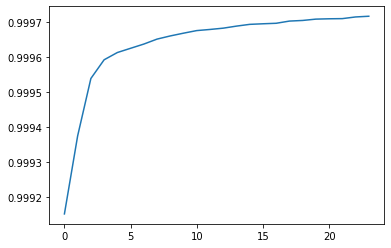

step: 0/2, D_loss: 2.990453, G_loss_U: 0.40209842, G_loss_S: 0.006284239, E_loss_t0: 2.165688


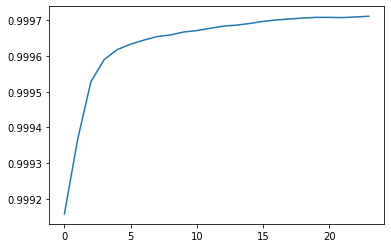

step: 0/2, D_loss: 2.5270872, G_loss_U: 0.53227824, G_loss_S: 0.0062683127, E_loss_t0: 2.1476083


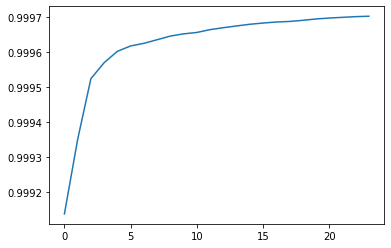

step: 0/2, D_loss: 2.2035565, G_loss_U: 0.66739106, G_loss_S: 0.006295599, E_loss_t0: 2.2121317


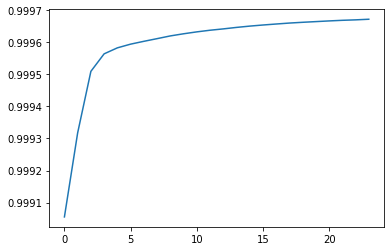

step: 0/2, D_loss: 2.0160606, G_loss_U: 0.7987168, G_loss_S: 0.0061779856, E_loss_t0: 2.2134256


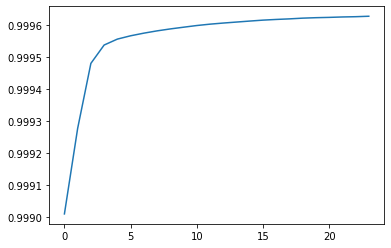

step: 0/2, D_loss: 1.9205184, G_loss_U: 0.92068243, G_loss_S: 0.006547418, E_loss_t0: 2.2095122


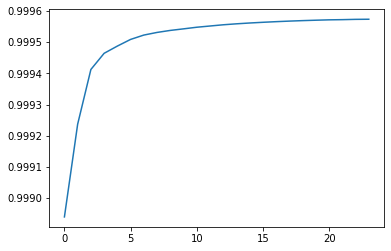

step: 0/2, D_loss: 1.8785675, G_loss_U: 1.0273427, G_loss_S: 0.0060302736, E_loss_t0: 2.1589549


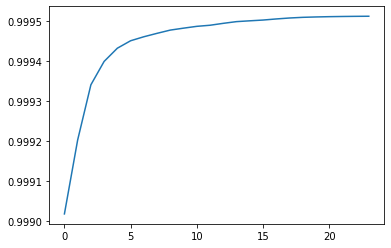

step: 0/2, D_loss: 1.8644166, G_loss_U: 1.1121227, G_loss_S: 0.005840355, E_loss_t0: 2.2147005


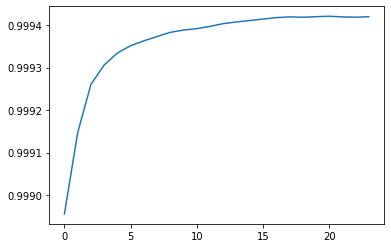

step: 0/2, D_loss: 1.8603892, G_loss_U: 1.1691041, G_loss_S: 0.0061901854, E_loss_t0: 2.1987028


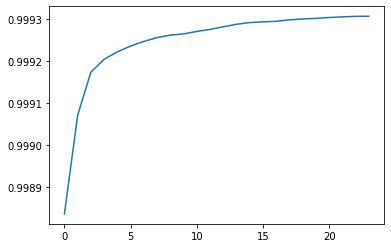

step: 0/2, D_loss: 1.857754, G_loss_U: 1.1947923, G_loss_S: 0.00582797, E_loss_t0: 2.2681758


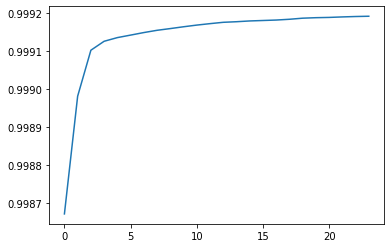

step: 0/2, D_loss: 1.8475534, G_loss_U: 1.1890877, G_loss_S: 0.006415325, E_loss_t0: 2.222678


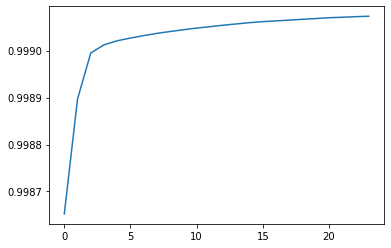

step: 0/2, D_loss: 1.8283981, G_loss_U: 1.1550764, G_loss_S: 0.0062972195, E_loss_t0: 2.1383293


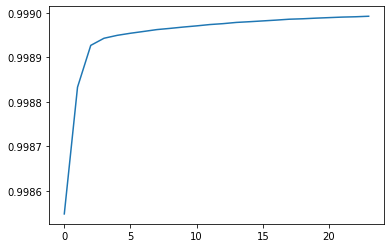

step: 0/2, D_loss: 1.8013971, G_loss_U: 1.0983299, G_loss_S: 0.006050396, E_loss_t0: 2.123731


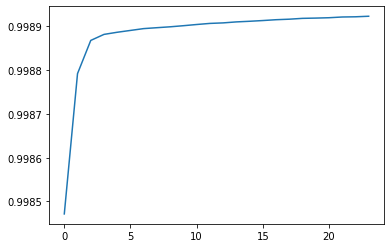

step: 0/2, D_loss: 1.7689948, G_loss_U: 1.0261761, G_loss_S: 0.006423928, E_loss_t0: 2.1797514


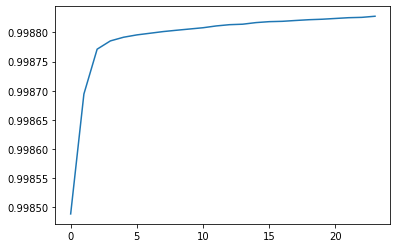

step: 0/2, D_loss: 1.7328758, G_loss_U: 0.94700724, G_loss_S: 0.0061936206, E_loss_t0: 2.1108212


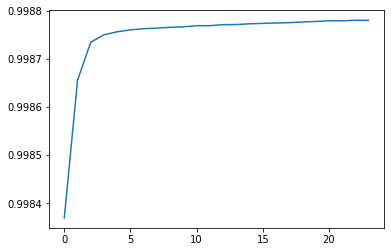

step: 0/2, D_loss: 1.6990945, G_loss_U: 0.86868376, G_loss_S: 0.006318079, E_loss_t0: 2.2051165


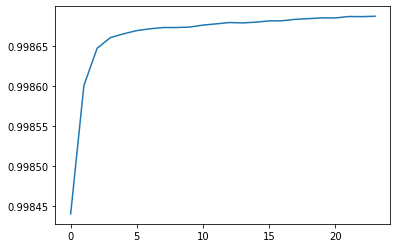

step: 0/2, D_loss: 1.6618806, G_loss_U: 0.7970111, G_loss_S: 0.005699341, E_loss_t0: 2.1049972


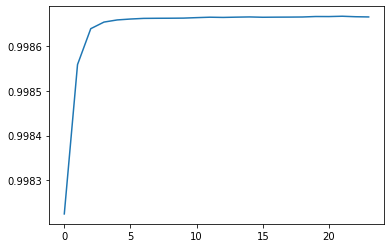

step: 0/2, D_loss: 1.6242012, G_loss_U: 0.73530936, G_loss_S: 0.006388434, E_loss_t0: 2.1761801


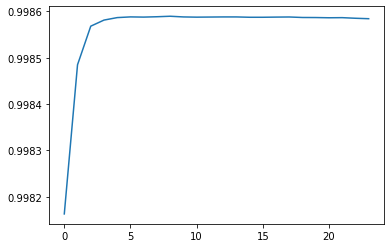

step: 0/2, D_loss: 1.5865419, G_loss_U: 0.6862581, G_loss_S: 0.005801568, E_loss_t0: 2.2071416


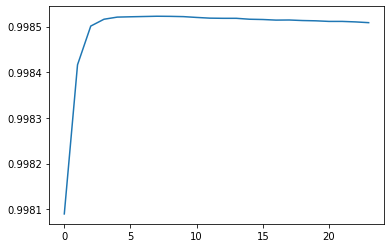

step: 0/2, D_loss: 1.5491813, G_loss_U: 0.65497947, G_loss_S: 0.0058335937, E_loss_t0: 2.1596715


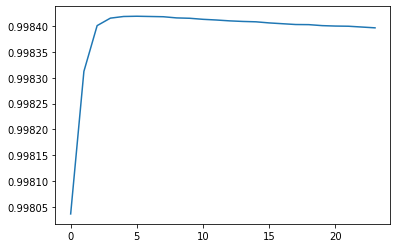

step: 0/2, D_loss: 1.5181143, G_loss_U: 0.6510353, G_loss_S: 0.00587142, E_loss_t0: 2.2020822


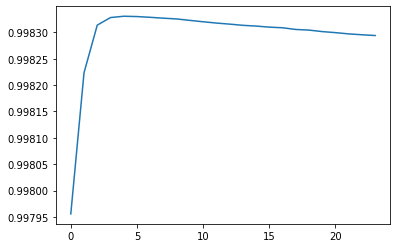

step: 0/2, D_loss: 1.4821975, G_loss_U: 0.69487125, G_loss_S: 0.0063957865, E_loss_t0: 2.1971588


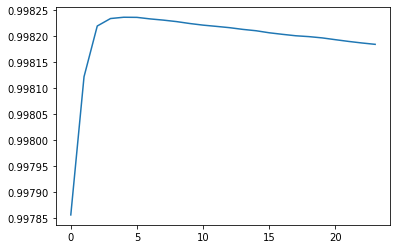

step: 0/2, D_loss: 1.4429839, G_loss_U: 0.83312386, G_loss_S: 0.0057524526, E_loss_t0: 2.2608519


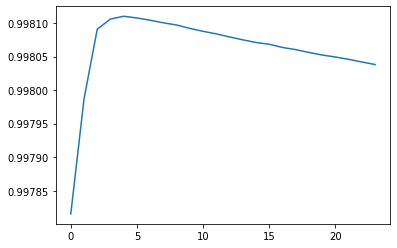

step: 0/2, D_loss: 1.3822042, G_loss_U: 1.1688379, G_loss_S: 0.0065415185, E_loss_t0: 2.202294


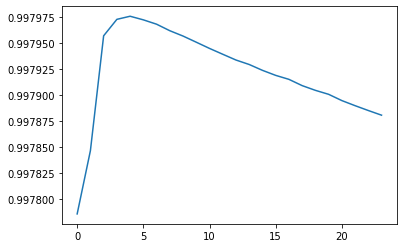

step: 0/2, D_loss: 1.3626974, G_loss_U: 0.73953766, G_loss_S: 0.00663908, E_loss_t0: 2.2230406


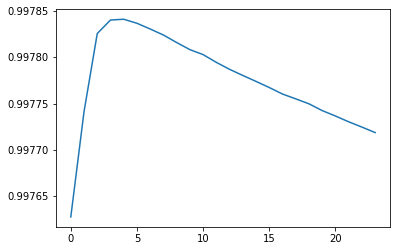

step: 0/2, D_loss: 1.2951199, G_loss_U: 0.8380812, G_loss_S: 0.0064137955, E_loss_t0: 2.2317638


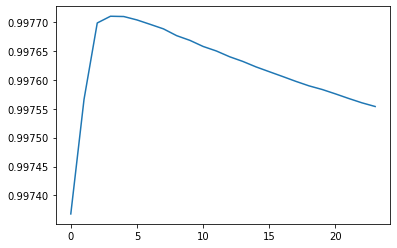

step: 0/2, D_loss: 1.1880155, G_loss_U: 1.9836206, G_loss_S: 0.00638855, E_loss_t0: 2.2167387


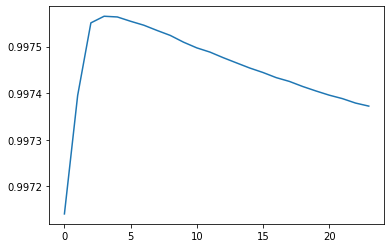

step: 0/2, D_loss: 1.7648443, G_loss_U: 1.5885978, G_loss_S: 0.0067279604, E_loss_t0: 2.2251334


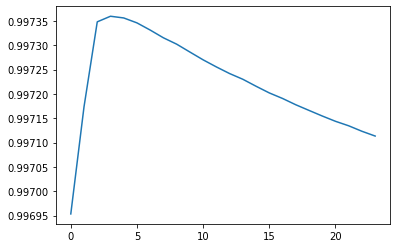

step: 0/2, D_loss: 0.9675709, G_loss_U: 0.44963118, G_loss_S: 0.006931994, E_loss_t0: 2.143197


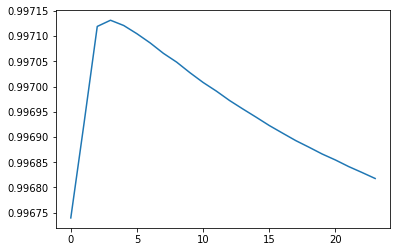

step: 0/2, D_loss: 1.4099841, G_loss_U: 0.3579704, G_loss_S: 0.0077466476, E_loss_t0: 2.2402458


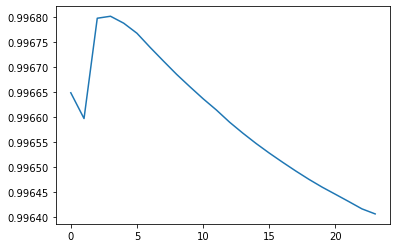

step: 0/2, D_loss: 1.545742, G_loss_U: 0.35800633, G_loss_S: 0.008292646, E_loss_t0: 2.2109363


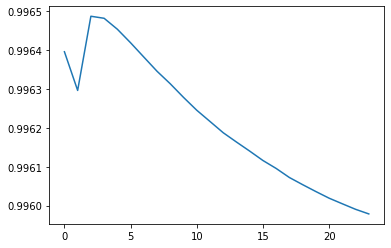

step: 0/2, D_loss: 1.5335246, G_loss_U: 0.41396597, G_loss_S: 0.008668523, E_loss_t0: 2.2885988


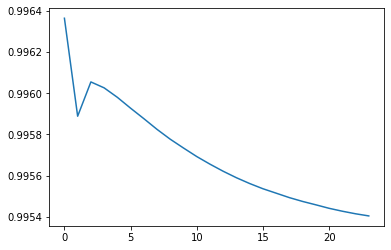

step: 0/2, D_loss: 1.420735, G_loss_U: 0.53916603, G_loss_S: 0.008627192, E_loss_t0: 2.244941


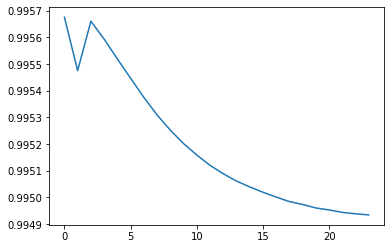

step: 0/2, D_loss: 1.2511957, G_loss_U: 0.7641943, G_loss_S: 0.009372782, E_loss_t0: 2.2390673


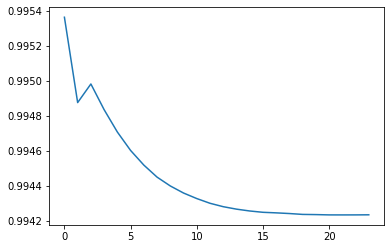

step: 0/2, D_loss: 1.0827955, G_loss_U: 1.0686538, G_loss_S: 0.010239758, E_loss_t0: 2.2099404


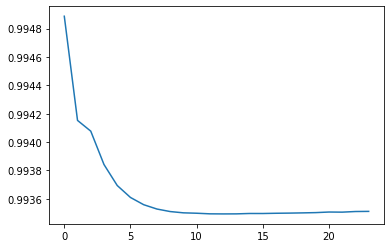

step: 0/2, D_loss: 0.9994486, G_loss_U: 1.3688612, G_loss_S: 0.010945619, E_loss_t0: 2.1248019


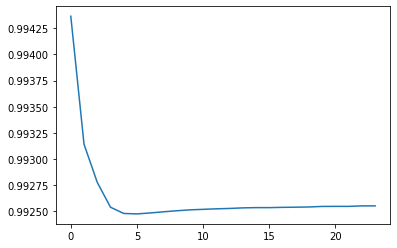

step: 0/2, D_loss: 1.0342293, G_loss_U: 1.5985241, G_loss_S: 0.010727854, E_loss_t0: 2.1811955


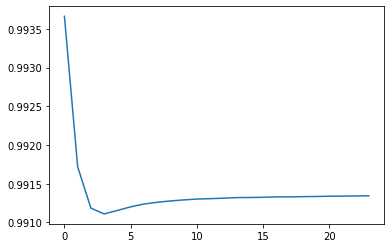

step: 0/2, D_loss: 1.0919445, G_loss_U: 1.7241751, G_loss_S: 0.011440109, E_loss_t0: 2.2466688


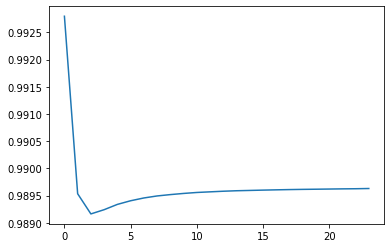

step: 0/2, D_loss: 1.062292, G_loss_U: 1.7480422, G_loss_S: 0.012715703, E_loss_t0: 2.1192703


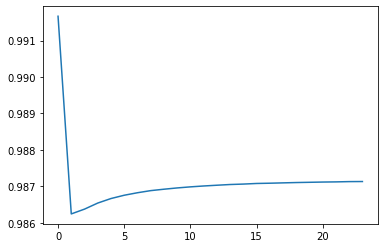

step: 0/2, D_loss: 1.0151469, G_loss_U: 1.6771703, G_loss_S: 0.013443945, E_loss_t0: 2.1893113


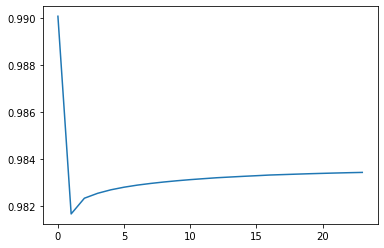

step: 0/2, D_loss: 0.90563846, G_loss_U: 1.5375785, G_loss_S: 0.014173511, E_loss_t0: 2.1799273


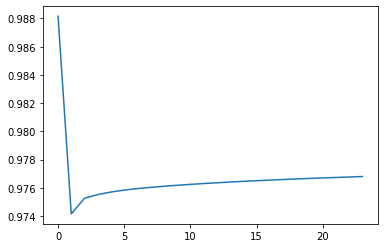

step: 0/2, D_loss: 0.785396, G_loss_U: 1.3760108, G_loss_S: 0.015388824, E_loss_t0: 2.1408267


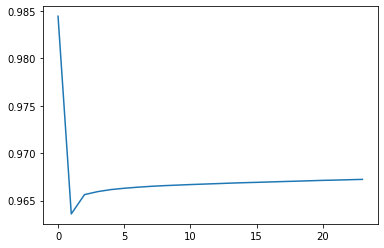

step: 0/2, D_loss: 0.70967484, G_loss_U: 1.2527375, G_loss_S: 0.015992464, E_loss_t0: 2.1596076


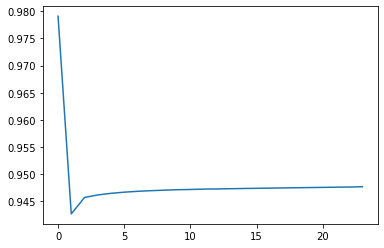

step: 0/2, D_loss: 0.6698433, G_loss_U: 1.240892, G_loss_S: 0.01690794, E_loss_t0: 2.221034


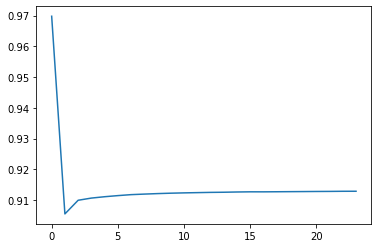

step: 0/2, D_loss: 0.60358953, G_loss_U: 1.4559731, G_loss_S: 0.018506264, E_loss_t0: 2.1092417


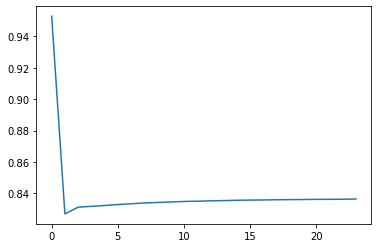

step: 0/2, D_loss: 0.48670816, G_loss_U: 1.9767333, G_loss_S: 0.021636581, E_loss_t0: 1.8861767


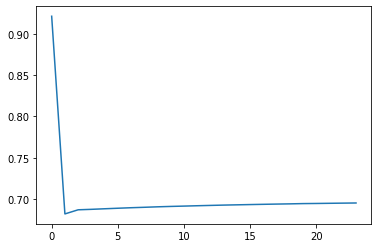

step: 0/2, D_loss: 0.35234216, G_loss_U: 2.5464518, G_loss_S: 0.023440124, E_loss_t0: 1.659985


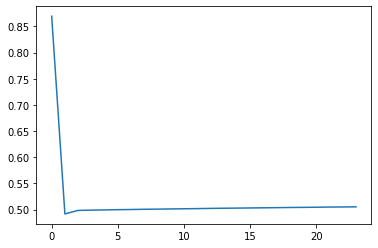

step: 0/2, D_loss: 0.2910264, G_loss_U: 2.9916458, G_loss_S: 0.022709848, E_loss_t0: 1.7441691


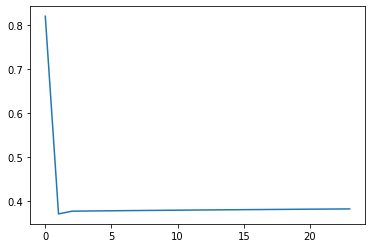

step: 0/2, D_loss: 0.23880857, G_loss_U: 3.334999, G_loss_S: 0.025147358, E_loss_t0: 1.8970407


KeyboardInterrupt: 

In [13]:
Generator, Embedder, Supervisor, Recovery, Discriminator, test, test_recovery, checkpoints = TimeGAN(data, parameters)

In [ ]:
from utils import extract_time

In [ ]:
random_test = random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])

In [ ]:
torch.tensor(random_test).shape

Oben wird die selbe anzahl an Noise-Daten wie in den echten Daten erzeugt, und dann in den Generator geworfen; Das wird dann wiederrum in die Recovery gegeben, und darauf dann die Visualisierung gemacht

In [ ]:
test.shape

In [ ]:
test

In [ ]:
test = torch.reshape(test, (12800, seq_len, 40))

In [ ]:
test.shape

In [ ]:
test_recovery = Recovery(test)

In [ ]:
test_recovery = torch.reshape(test_recovery[0], (12800, seq_len, dim))

In [ ]:
test_recovery.shape

In [11]:
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.
Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.
Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks
Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------
visualization_metrics.py
Note: Use PCA or tSNE for generated and original data visualization
"""

# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()  
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

In [ ]:
visualization(data, test_recovery.detach().numpy(), 'tsne')

In [ ]:
visualization(data, test_recovery.detach().numpy(), 'pca')

In [ ]:
fig, ax = plt.subplots()
ax1 = plt.plot(test_recovery[0].detach().numpy())


In [ ]:
for i in range(0,test_recovery.shape[0]):
    
    if i % 100 == 0:
        fig, ax = plt.subplots()
        ax1 = plt.plot(test_recovery[i].detach().numpy())

In [ ]:
test_recovery.shape

In [ ]:
test[0].shape

In [ ]:
data

In [ ]:
fig, ax = plt.subplots()
ax1 = plt.plot(data[0].detach().numpy())


In [ ]:
test_recovery[0]

In [ ]:
test_recovery[5000]

In [ ]:
test_recovery[0]

In [ ]:
fig, ax = plt.subplots()

ax1 = plt.plot(data[0].detach().numpy())

In [ ]:
fig, ax = plt.subplots()

ax1 = plt.plot(data[5000].detach().numpy())